In [13]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

In [14]:
import numpy as np

import gym
from gym import Env
from gym.spaces import Box
from gym.utils import seeding

import math

model_name = "ppo2_meters_redesigned_1"
class DifferentialDriveEnv(Env):
  """Custom Environment that follows gym interface"""
  # metadata = {'render.modes': ['human']}
  metadata = {'render.modes': ['console']}

  #def __init__(self, L, r, delta_t = 0.01, init_position=None, goal_position=[0,0], min_action=-5, max_action=5, min_position=[-10,-10], max_position=[10,10]):
  #def __init__(self, L, r, delta_t = 0.01, init_position=None, goal_position=[0,0], min_action=-5, max_action=5, min_position=[-0.1,-0.1], max_position=[0.1,0.1]):
  #def __init__(self, L, r, delta_t = 0.01, init_position=None, goal_position=[0,0], min_action=-3, max_action=3, min_position=[-0.1,-0.1], max_position=[0.1,0.1]):
  def __init__(self, L, r, delta_t = 0.01, init_position=None, goal_position=[0,0], min_action=-3, max_action=3, min_position=[-1,-1], max_position=[1,1]):
    super(DifferentialDriveEnv, self).__init__()

    #Define model parameters
    self.L = L 
    self.r = r

    self.delta_t = delta_t

    # Define action and observation space
    # They must be gym.spaces objects
    self.min_action = min_action
    self.max_action = max_action
    self.min_position = min_position
    self.max_position = max_position

    self.min_orientation = -math.pi
    self.max_orientation = math.pi
    
    self.init_position = init_position
    self.goal_position = goal_position

    # self.goal_velocity = goal_velocity
    # self.goal_orientation = goal_orientation
    self.goal_reached_count = 0

    self.max_duration = 500
    #self.max_duration = 250
    
    self.low_state = np.array(
        self.min_position+[self.min_orientation], dtype=np.float32
    )

    self.high_state = np.array(
        self.max_position+[self.max_orientation], dtype=np.float32
    )

    self.viewer = None

    self.action_space = Box(
        low=self.min_action,
        high=self.max_action,
        #low=-1,
        #high=1,
        shape=(2,),
        dtype=np.float32
    )

    self.observation_space = Box(
        low=self.low_state,
        high=self.high_state,
        shape=(3,),
        dtype=np.float32
    )

    self.seed()
    self.reset()

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def reset(self):
    # Reset the state of the environment to an initial state

    if self.init_position is None:
       self.state = np.array([self.np_random.uniform(low=-0.1, high=0.1), self.np_random.uniform(low=-0.5, high=0.5), -math.pi/2+self.np_random.uniform(low=-0.01, high=0.01)])
      #self.state = np.array([self.np_random.uniform(low=-0.03, high=-0.02), self.np_random.uniform(low=-0.02, high=-0.01), -math.pi/2])
      #self.state = np.array([self.np_random.uniform(low=0.02, high=0.03), self.np_random.uniform(low=-0.02, high=-0.01), -math.pi/2])
      # self.state = np.array([self.np_random.uniform(low=self.min_position[0], high=self.max_position[0]), self.np_random.uniform(low=self.min_position[0], high=self.max_position[0]), math.pi/2])
    elif isinstance(self.init_position, list):
      if len(self.init_position) == 3:
        self.state = np.array(self.init_position)
      else:
        raise Exception("Initial position must be size 3: [x, y, theta]")
    else:
      raise Exception("Initial position must be a list: [x, y, theta]")
    #self.max_duration = 500
    self.max_duration = 500
    return np.array(self.state)

  def render(self, mode='console', close=False):
    if mode is 'console':
      print("========================================================")
      print(">> Pos: x = ",self.state[0],"; y = ",self.state[1])
      print(">> Ori: ",self.state[2])
      print("========================================================")

  def step(self, action):
    x = self.state[0]
    y = self.state[1]
    theta = self.state[2]

    v = (action[1] + action[0]) * self.r / 2      #max vlin = 2 * 3 *0.15 /2 = 3*0.15 = 0.45 m/s (was 0.75 wmax = 5)
    w = (action[1] - action[0]) * self.r / self.L #max omega = 3 - (-3) * 0.15 /0.5 = 0.9 /0.5  1,8 rad/s ()

    x = x + v * self.delta_t * math.cos(theta)
    y = y + v * self.delta_t * math.sin(theta)
    theta = theta + w * self.delta_t

    #threshold = 0.1
    #threshold = 0.001
    threshold = 0.1
    distance_to_target = np.linalg.norm(np.array(self.goal_position)-np.array([x, y]))

    goal_reached = bool(distance_to_target <= threshold)
    too_far = bool(distance_to_target > 0.1)

    reward = 0
    #if done:
    if goal_reached:
      reward = 100.0
      self.goal_reached_count += 1
    # reward -= math.pow(action[0], 2) * 0.1
    #when distance is 1000 cm it gets a negative reward = -100
    #reward -= float(np.linalg.norm(np.array(self.goal_position)-np.array([x, y]))/10
    #when distance =  10 m it gets a negative rewards of -100
    #reward -= float(np.linalg.norm(np.array(self.goal_position)-np.array([x, y])))*10
    reward -= distance_to_target *0.1
    #if self.max_duration <= 0: 
    #        done = True
    #else:
    #        done = False
    #done = goal_reached or too_far or bool(self.max_duration <= 0)
    done = goal_reached or bool(self.max_duration <= 0)
    info = {}

    self.state = np.array([x, y, theta])

    self.max_duration -= 1

    return self.state, reward, done, info

  def close(self):
    pass

In [15]:
from stable_baselines.common.env_checker import check_env

#env = DifferentialDriveEnv(L=50, r=15)
env = DifferentialDriveEnv(L=0.5, r=0.15)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

/usr/local/lib/python3.7/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [16]:
import gym

#env = DifferentialDriveEnv(L=50, r=15)
env = DifferentialDriveEnv(L=0.5, r=0.15)

# Box(4,) means that it is a Vector with 4 components
print("Observation space:", env.observation_space)
print("Shape:", env.observation_space.shape)
# Discrete(2) means that there is two discrete actions
print("Action space:", env.action_space)

# The reset method is called at the beginning of an episode
obs = env.reset()
print("Reset state: ", obs)

# Sample a random action
action = env.action_space.sample()
print("Sampled action:", action)
obs, reward, done, info = env.step(action)
# Note the obs is a numpy array
# info is an empty dict for now but can contain any debugging info
# reward is a scalar
print(obs, reward, done, info)
env.render()

Observation space: Box(-3.1415927410125732, 3.1415927410125732, (3,), float32)
Shape: (3,)
Action space: Box(-3.0, 3.0, (2,), float32)
Reset state:  [-0.09626175  0.36158992 -1.57710256]
Sampled action: [2.4454195 1.1506755]
[-0.09627876  0.3588929  -1.58098679] -0.037158271666773546 False {}
>> Pos: x =  -0.096278761493519 ; y =  0.35889290242556854
>> Ori:  -1.5809867918184612


In [17]:
import time

#env = DifferentialDriveEnv(L=50, r=15)
env = DifferentialDriveEnv(L=0.5, r=0.15)
for i_episode in range(20):
    observation = env.reset()
    done = False
    score = 0
    for t in range(50):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        score+=reward
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    print('---------------------------Episode:{} Score:{}------------------------------'.format(i_episode, score))
    time.sleep(5)
env.close()

>> Pos: x =  -0.06295123140676798 ; y =  0.13625021942022475
>> Ori:  -1.56244961629926
[-0.06295123  0.13625022 -1.56244962]
>> Pos: x =  -0.0629564250397284 ; y =  0.13687244207348395
>> Ori:  -1.5604795995813492
[-0.06295643  0.13687244 -1.5604796 ]
>> Pos: x =  -0.06294304048750744 ; y =  0.13557512393377086
>> Ori:  -1.5626446751218919
[-0.06294304  0.13557512 -1.56264468]
>> Pos: x =  -0.06294017109005383 ; y =  0.13522312975984974
>> Ori:  -1.5492457007032516
[-0.06294017  0.13522313 -1.5492457 ]
>> Pos: x =  -0.06296876932058357 ; y =  0.13654994982456173
>> Ori:  -1.5516218855839852
[-0.06296877  0.13654995 -1.55162189]
>> Pos: x =  -0.06299939163137938 ; y =  0.13814679207456396
>> Ori:  -1.5428016043168191
[-0.06299939  0.13814679 -1.5428016 ]
>> Pos: x =  -0.06292442742970145 ; y =  0.13546969400892042
>> Ori:  -1.544586560414422
[-0.06292443  0.13546969 -1.54458656]
>> Pos: x =  -0.06293637969318572 ; y =  0.1359256128564574
>> Ori:  -1.5411190013152245
[-0.06293638  0.135

In [18]:
from stable_baselines import DQN, PPO2, A2C, ACKTR, TRPO
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.policies import MlpPolicy


# Instantiate the env
#env = DifferentialDriveEnv(L=50, r=15)
env = DifferentialDriveEnv(L=0.50, r=0.15)
# wrap it
env = make_vec_env(lambda: env, n_envs=4)

# Train the agent
model = PPO2(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=5000000)
model.save(model_name) #typo, the zip is renamed as ppo2

Streaming output truncated to the last 5000 lines.
| serial_timesteps   | 1207296        |
| time_elapsed       | 1.49e+03       |
| total_timesteps    | 4829184        |
| value_loss         | 261.3203       |
---------------------------------------
--------------------------------------
| approxkl           | 0.00021829079 |
| clipfrac           | 0.00048828125 |
| ep_len_mean        | 226           |
| ep_reward_mean     | 56.6          |
| explained_variance | -1.53         |
| fps                | 3543          |
| n_updates          | 9433          |
| policy_entropy     | 6.0872884     |
| policy_loss        | -0.0016266856 |
| serial_timesteps   | 1207424       |
| time_elapsed       | 1.49e+03      |
| total_timesteps    | 4829696       |
| value_loss         | 18.992802     |
--------------------------------------
---------------------------------------
| approxkl           | 0.0002961404   |
| clipfrac           | 0.0            |
| ep_len_mean        | 229            |
| ep

In [19]:
print("Goal reached in env 0: {} times".format(env.envs[0].goal_reached_count))
print("Goal reached in env 1: {} times".format(env.envs[1].goal_reached_count))
print("Goal reached in env 2: {} times".format(env.envs[2].goal_reached_count))
print("Goal reached in env 3: {} times".format(env.envs[3].goal_reached_count))

del env
del model

Goal reached in env 0: 6892 times
Goal reached in env 1: 6892 times
Goal reached in env 2: 6892 times
Goal reached in env 3: 6892 times


In [20]:
#env = DifferentialDriveEnv(L=50, r=15)
init_pose = [-0.05, -0.25, -np.pi/2]
env = DifferentialDriveEnv(L=0.5, r=0.15,init_position=init_pose)
model = PPO2.load(model_name) #typo it should be ppo_etc
obs = env.reset()
while False:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render(mode = 'console')

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [21]:
def show_rl_trajectory(obs_list):
    x_values = list(map(lambda obs: obs[0], obs_list))
    y_values = list(map(lambda obs: obs[1], obs_list))
    theta_values = list(map(lambda obs: obs[2], obs_list))
    print("Starting point: x:{}, y:{} -PURPLE-".format(x_values[0],y_values[0]))
    print("End point: x:{}, y:{} -GREEN-".format(x_values[-1],y_values[-1]))
    def on_close(event):
        print('Closed Figure!')
        
    fig = plt.figure()
    fig.canvas.mpl_connect('close_event', on_close)
    plt.scatter(x_values, y_values,color='blue')
    plt.scatter(x_values[0],y_values[0],color='purple')
    plt.scatter(x_values[-1],y_values[-1],color='green')
    plt.scatter(0,0,color='red',marker='x')
    plt.axis("equal")
    plt.grid()
    plt.show()

Step 1
Action:  [-3.  3.]
obs= [-0.05       -0.25       -1.55279633] reward= -0.025495097567963927 done= False
>> Pos: x =  -0.05 ; y =  -0.25
>> Ori:  -1.5527963267948965
Step 2
Action:  [-3.  3.]
obs= [-0.05       -0.25       -1.53479633] reward= -0.025495097567963927 done= False
>> Pos: x =  -0.05 ; y =  -0.25
>> Ori:  -1.5347963267948965
Step 3
Action:  [-3.  3.]
obs= [-0.05       -0.25       -1.51679633] reward= -0.025495097567963927 done= False
>> Pos: x =  -0.05 ; y =  -0.25
>> Ori:  -1.5167963267948965
Step 4
Action:  [-3.  3.]
obs= [-0.05       -0.25       -1.49879633] reward= -0.025495097567963927 done= False
>> Pos: x =  -0.05 ; y =  -0.25
>> Ori:  -1.4987963267948965
Step 5
Action:  [-3.  3.]
obs= [-0.05       -0.25       -1.48079633] reward= -0.025495097567963927 done= False
>> Pos: x =  -0.05 ; y =  -0.25
>> Ori:  -1.4807963267948965
Step 6
Action:  [-3.  3.]
obs= [-0.05       -0.25       -1.46279633] reward= -0.025495097567963927 done= False
>> Pos: x =  -0.05 ; y =  -0.

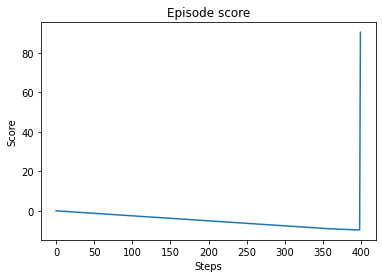

Starting point: x:-0.05, y:-0.25 -PURPLE-
End point: x:-0.05217676818992509, y:-0.0847796305147371 -GREEN-


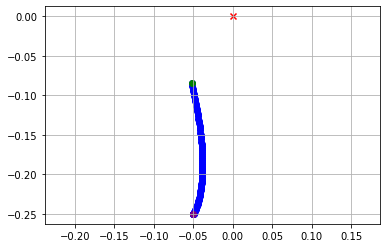

In [22]:
import matplotlib.pyplot as plt

obs = env.reset()
n_steps = 500
score = 0.0
history = []
obss = []
obss.append(obs)
history.append(score)
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console',close = True)
  score+=float(reward)
  history.append(score)
  obss.append(obs)
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

plt.plot(history)
plt.title('Episode score')
plt.ylabel('Score')
plt.xlabel('Steps')
plt.show()
show_rl_trajectory(obss)